In [22]:

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import os
import copy
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from multi_gran_generator import creat_coarse_data
from mgtsd_estimator import mgtsdEstimator
from trainer import Trainer
from pathlib import Path
import wandb
import ast
from multi_gran_generator_all import creat_coarse_data_elec

def parse_args():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_name', type=str, default='mgtsd', help='model name')
    parser.add_argument('--dataset', type=str, default="solar")
    parser.add_argument('--cuda_num', type=str, default='3')
   
    parser.add_argument('--result_path', type=str, default='./results/')
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--learning_rate', type=float, default=1e-05)
    parser.add_argument('--share_hidden',type=str,default="False")
    parser.add_argument('--setting',type=int, default=0) #weighted add
    parser.add_argument('--num_cells',type=int, default=128)
    parser.add_argument('--diff_steps', type=int, default=100)
    

    parser.add_argument('--input_size', type=int, default=552)
    parser.add_argument('--batch_size', type=int, default=128)
    parser.add_argument('--mg_dict',type = str, default='1_4')
    parser.add_argument('--num_gran',type=int, default=2)
    parser.add_argument('--share_ratio_list',type=str, default="1_0.9")
    parser.add_argument('--weight_list',type=str, default="0.9_0.1")
    parser.add_argument('--run_num',type=str, default="0")
    parser.add_argument('--wandb_space',type=str, default="test")
    parser.add_argument('--wandb_key',type=str, default="94cc33acc0d4f4be3396e28131e30d1f057d3487")

    # 返回一个命名空间，包含传递给命令的参数
    return parser.parse_args()

alias = {
    'fina': 'm3_other',
    'elec': 'electricity_nips',
    'exc': 'exchange_rate_nips',
    'wiki': 'wiki-rolling_nips',
    'cup': 'kdd_cup_2018_without_missing',
    'solar': 'solar_nips',
    'traf': 'traffic_nips',
    'fred': 'fred_md',
    'taxi': 'taxi_30min'
}
input_size_all = {
    'fred': 323,
    'solar': 552,
    'cup': 1084,
    'traf': 3856,
    'taxi': 7290,
    'elec':1484
}
feature_size_all = {
    'fred': 107,
    'solar': 137,
    'cup': 270,
    'traf': 963,
    'taxi': 1214,
    'elec':370
}
dataset_name = 'elec'
mg_dict=[float(i) for i in str('1_4_8_12').split('_')]
print(f"mg_dict:{mg_dict}")

dataset = get_dataset(alias[dataset_name], regenerate=False)

train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

print("prepare the dataset")
dataset_train=train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)
if dataset_name == 'elec':
    print(f'truncate elec')
    data_train, data_test = creat_coarse_data_elec(dataset_train=dataset_train, 
                                          dataset_test=dataset_test, 
                                          mg_dict=mg_dict)
else:
    data_train, data_test = creat_coarse_data(dataset_train=dataset_train, 
                                          dataset_test=dataset_test, 
                                          mg_dict=mg_dict)




mg_dict:[1.0, 4.0, 8.0, 12.0]
prepare the dataset
len_all: 370
first_timestamp: 2014-01-01 00:00, last_timestamp: 2014-09-01 00:00
train _prepare_train_data
len_all: 2590
first_timestamp: 2014-03-19 09:00, last_timestamp: 2014-09-08 00:00
test _prepare_test_data


/data/wuyy/miniconda3/envs/time4/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return {FieldName.TARGET: np.array([funcs(data) for data in dataset])}


truncate elec


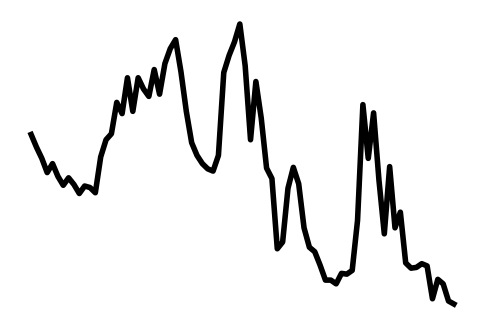

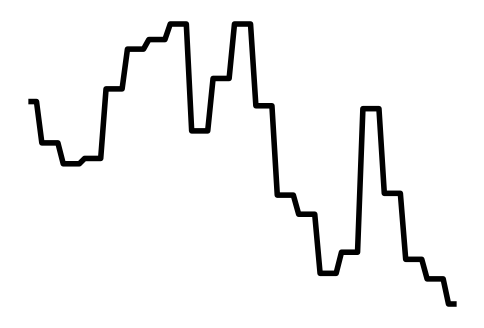

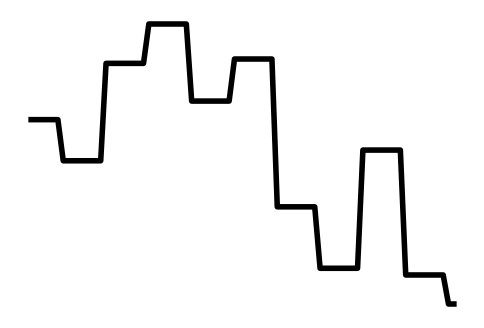

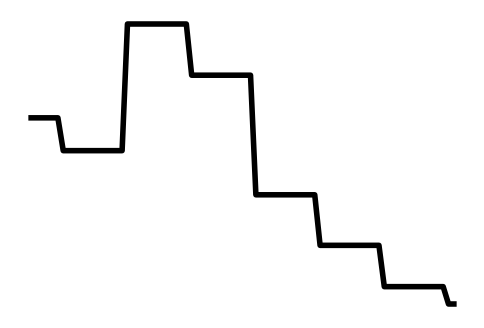

In [25]:
indexs = [0,370,370*2,370*3]
for index in indexs:
    nums = data_train[0]['target'][index][1050:1130]
    plt.figure(figsize=(6,4))
    plt.plot(nums, 'k-',linewidth=4)
    plt.axis('off')
    # plt.show()
    plt.savefig(f'./pic/{index}.svg', format='svg', bbox_inches='tight', pad_inches=0, dpi=300)
